# Hyper parameters tuning methods comparison

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sklearn
import sys
import seaborn as sns

### Load the data

In [2]:
dataset = pd.read_csv(
    "/Users/camille.hascoet/Documents/greenai/src/hale/data/mars-2014-complete.csv",
    sep=";",
)  # type: pd.DataFrame
dataset = dataset.dropna()  # Drop rows with missing values

dataset.head()

lib_mrq lib_mod_doss   lib_mod  \
2461    JEEP      COMPASS   COMPASS   
2462    JEEP      COMPASS   COMPASS   
2463    JEEP      COMPASS   COMPASS   
2491    JEEP     WRANGLER  WRANGLER   
2492    JEEP     WRANGLER  WRANGLER   

                                          dscom             cnit  \
2461  COMPASS (2014) 2.2 l CRD BVM6 4x2 (136ch)  M10JEPVP000W538   
2462  COMPASS (2014) 2.2 l CRD BVM6 4x4 (136ch)  M1GJEPVP000A536   
2463  COMPASS (2014) 2.2 l CRD BVM6 4x4 (163ch)  M1GJEPVP000B537   
2491     WRANGLER (2012) 2.8 L CRD BVA5 RUBICON  M10JEPVP0006221   
2492     WRANGLER (2012) 2.8 L CRD BVA5 RUBICON  M1GJEPVP000D309   

                tvv cod_cbr hybride  puiss_admin_98 puiss_max  ...     hc  \
2461  PKJACFJE5LD1A      GO     non               8       100  ...  0.022   
2462  PKJA5FJE5LD1A      GO     non               8       100  ...  0.022   
2463  PKJA5FJE5MD1A      GO     non              10       120  ...  0.022   
2491  JKJVJE9C4HD3A      GO     non              13       147  ...  0.015   
2492  JKJVJE9C4HD3A      GO     non              13       147  ...  0.015   

        nox  hcnox  ptcl  masse_ordma_min  masse_ordma_max  \
2461  0.121  0.154   0.0             1609             1678   
2462  0.121  0.154   0.0             1680             1730   
2463  0.121  0.154   0.0             1680             1730   
2491  0.133  0.149   0.0             1933             2075   
2492  0.133  0.149   0.0             1933             2075   

                    champ_v9  date_maj          Carrosserie      gamme  
2461  715/2007*630/2012EURO5   juin-13  TS TERRAINS/CHEMINS  MOY-SUPER  
2462  715/2007*630/2012EURO5   juin-13  TS TERRAINS/CHEMINS  MOY-SUPER  
2463  715/2007*630/2012EURO5   juin-13  TS TERRAINS/CHEMINS  MOY-SUPER  
2491  715/2007*692/2008EURO5   juin-13  TS TERRAINS/CHEMINS  MOY-SUPER  
2492  715/2007*692/2008EURO5   juin-13  TS TERRAINS/CHEMINS  MOY-SUPER  

[5 rows x 26 columns]

In [3]:
# print columns names
print(dataset.columns)

Index(['lib_mrq', 'lib_mod_doss', 'lib_mod', 'dscom', 'cnit', 'tvv', 'cod_cbr',
       'hybride', 'puiss_admin_98', 'puiss_max', 'typ_boite_nb_rapp',
       'conso_urb', 'conso_exurb', 'conso_mixte', 'co2', 'co_typ_1', 'hc',
       'nox', 'hcnox', 'ptcl', 'masse_ordma_min', 'masse_ordma_max',
       'champ_v9', 'date_maj', 'Carrosserie', 'gamme'],
      dtype='object')


In [4]:
target = "co2"
X = dataset.drop(target, axis=1)  # features
y = dataset[target]  # target variable

var_num = X.select_dtypes(
    include=[float, int]
).columns.tolist()  # list of numerical variables
var_cat = X.select_dtypes(
    include=[object]
).columns.tolist()  # list of categorical variables

In [5]:
var_num

['puiss_admin_98',
 'conso_urb',
 'conso_exurb',
 'conso_mixte',
 'co_typ_1',
 'hc',
 'nox',
 'hcnox',
 'ptcl',
 'masse_ordma_min',
 'masse_ordma_max']

In [6]:
var_cat

['lib_mrq',
 'lib_mod_doss',
 'lib_mod',
 'dscom',
 'cnit',
 'tvv',
 'cod_cbr',
 'hybride',
 'puiss_max',
 'typ_boite_nb_rapp',
 'champ_v9',
 'date_maj',
 'Carrosserie',
 'gamme']

In [7]:
# correlation matrix with numerical variables and target
corr_matrix = dataset.drop(var_cat, axis=1).corr()  # Compute the correlation matrix
corr_matrix[target].sort_values(
    ascending=False
)  # Sort the correlation values with the target variable

co2                1.000000
conso_mixte        0.999561
conso_exurb        0.995416
conso_urb          0.994763
puiss_admin_98     0.944656
masse_ordma_max    0.925491
masse_ordma_min    0.898020
nox               -0.046806
hcnox             -0.325448
hc                -0.790523
co_typ_1          -0.942465
ptcl                    NaN
Name: co2, dtype: float64

In [8]:
# drop columns with low correlation, ptcl and nox from var_num
var_num.remove("ptcl")
var_num.remove("nox")

In [9]:
# check which categorical variables have a low cardinality
cardinality = X[var_cat].nunique()

print(cardinality)

cardinality = cardinality[cardinality <= 10].index.tolist()

print(cardinality)

# drop the columns with high cardinality

lib_mrq               2
lib_mod_doss          4
lib_mod               3
dscom                21
cnit                 36
tvv                  30
cod_cbr               1
hybride               1
puiss_max             4
typ_boite_nb_rapp     3
champ_v9              3
date_maj              2
Carrosserie           2
gamme                 2
dtype: int64
['lib_mrq', 'lib_mod_doss', 'lib_mod', 'cod_cbr', 'hybride', 'puiss_max', 'typ_boite_nb_rapp', 'champ_v9', 'date_maj', 'Carrosserie', 'gamme']


## Création de notre preprocessor & séparation des données train/test

In [10]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

In [11]:
numerical_pipeline = make_pipeline(StandardScaler())
categorical_pipeline = make_pipeline(
    OneHotEncoder(handle_unknown="ignore")
)  # handle_unknown='ignore' to avoid errors when new categories appear in the test set

preprocessor = make_column_transformer(
    (numerical_pipeline, var_num), (categorical_pipeline, cardinality), remainder="drop"
)  # remainder='drop' to drop the columns that are not in var_num or cardinality

In [12]:
X = X.drop(X.columns.difference(var_num + cardinality), axis=1)

In [13]:
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1)).ravel()

In [14]:
# drop columns with low correlation, ptcl and nox from var_num and low cardinality from var_cat
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

## Essais de différents algos de ML et comparaison des différentes méthodes pour trouver les hyper-paramètres

In [15]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

In [16]:
# import grid search, random search and bayesian optimization

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV

In [17]:
import time
import codecarbon
from codecarbon import EmissionsTracker


def find_hp(search_method, model, param_grid, cv, X_train, y_train):

    if search_method == "grid":
        search = GridSearchCV(model, param_grid, cv=cv, n_jobs=-1, error_score="raise")
    elif search_method == "random":
        search = RandomizedSearchCV(
            model, param_grid, cv=cv, n_jobs=-1, error_score="raise"
        )  # error_score='raise' to avoid errors when the model fails to fit
    elif search_method == "bayesian":
        bayesian_param_dict = {}
        for key, value in param_grid.items():
            try:
                bayesian_param_dict[key] = tuple(min(value), max(value))
            except:
                bayesian_param_dict[key] = value
        search = BayesSearchCV(
            model, param_grid, cv=cv, n_jobs=-1, n_iter=20, error_score="raise"
        )

    search.fit(X_train, y_train)
    return search


def find_all_hp(search_methods, model, param_grid, cv, X_train, y_train):

    methods_dict = {}

    for search_method in search_methods:
        tracker = EmissionsTracker(log_level="critical", save_to_file=False)
        tracker.start()
        start = time.time()
        search = find_hp(search_method, model, param_grid, cv, X_train, y_train)
        end = time.time()
        co2 = tracker.stop()

        methods_dict[search_method] = {
            "search": search,
            "time": end - start,
            "emissions": co2 * 1000,
        }

    return methods_dict


search_methods = ["random", "grid", "bayesian"]

### SVC

In [18]:
svc_model = SVR()

svc_params_little = {
    "C": [0.1, 1, 10],
    "gamma": [0.1, 1, 10],
    "kernel": ["rbf", "linear"],
}
svc_params_medium = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [0.1, 1, 5, 10],
    "kernel": ["rbf", "linear", "poly"],
    "degree": [2, 3, 4, 5],
}
svc_params_big = {
    "C": [0.01, 0.1, 1, 10, 100],
    "gamma": [0.1, 1, 5, 10],
    "kernel": ["rbf", "linear", "poly"],
    "degree": [2, 3, 4, 5],
    "epsilon": [0.1, 0.2, 0.5, 1],
}

svc_dict_little = find_all_hp(
    search_methods, svc_model, svc_params_little, 5, X_train, y_train
)
svc_dict_medium = find_all_hp(
    search_methods, svc_model, svc_params_medium, 5, X_train, y_train
)
svc_dict_big = find_all_hp(
    search_methods, svc_model, svc_params_big, 5, X_train, y_train
)

/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 10, 'linear'] before, using random point [1, 0.1, 'linear']
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 10, 'linear'] before, using random point [1, 1, 'linear']
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [1, 10, 'linear'] before, using random point [10, 0.1, 'linear']
  warnings.warn(
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via readSample] returned 0xe00002bc
ERROR: EnergyDriver_executeCommands [via re

## Random Forest

In [19]:
rf_model = RandomForestRegressor()
rf_params_little = {
    "n_estimators": [10, 100],
    "max_depth": [10, 100],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 10],
}
rf_params_medium = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [10, 100, 1000],
    "min_samples_split": [2, 10, 100],
    "min_samples_leaf": [1, 10, 100],
}
rf_params_big = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [10, 100, 1000],
    "min_samples_split": [2, 5, 10, 100],
    "min_samples_leaf": [1, 10, 100],
    "max_features": ["sqrt", "log2"],
}

rf_dict_little = find_all_hp(
    search_methods, rf_model, rf_params_little, 5, X_train, y_train
)
rf_dict_medium = find_all_hp(
    search_methods, rf_model, rf_params_medium, 5, X_train, y_train
)
rf_dict_big = find_all_hp(search_methods, rf_model, rf_params_big, 5, X_train, y_train)

/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [10, 100] was inferred to Integer(low=10, high=100, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(10, 100), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [10, 100] was inferred to Integer(low=10, high=100, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(10, 100), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [2, 10] was inferred to Integer(l

## MLP

In [20]:
mlp_model = MLPRegressor()

mlp_params_little = {
    "hidden_layer_sizes": [(100), (200)],
    "activation": ["relu", "tanh"],
    "alpha": [0.0001, 0.001],
}
mlp_params_medium = {
    "hidden_layer_sizes": [(100), (200), (300)],
    "activation": ["relu", "tanh", "logistic"],
    "alpha": [0.0001, 0.001, 0.01],
}
mlp_params_big = {
    "hidden_layer_sizes": [(100), (200), (300)],
    "activation": ["relu", "tanh", "logistic"],
    "alpha": [0.0001, 0.001, 0.01],
    "learning_rate": ["constant", "invscaling", "adaptive"],
}

mlp_dict_little = find_all_hp(
    search_methods, mlp_model, mlp_params_little, 5, X_train, y_train
)
mlp_dict_medium = find_all_hp(
    search_methods, mlp_model, mlp_params_medium, 5, X_train, y_train
)
mlp_dict_big = find_all_hp(
    search_methods, mlp_model, mlp_params_big, 5, X_train, y_train
)

/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [100, 200] was inferred to Integer(low=100, high=200, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(100, 200), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [0.0001, 0.001] was inferred to Real(low=0.0001, high=0.001, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(cate

## GBR

In [21]:
gbr_model = GradientBoostingRegressor()
gbr_params_little = {
    "n_estimators": [10, 100],
    "max_depth": [10, 100],
    "min_samples_split": [2, 10],
    "min_samples_leaf": [1, 10],
}
gbr_params_medium = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [10, 100, 1000],
    "min_samples_split": [2, 10, 100],
    "min_samples_leaf": [1, 10, 100],
}
gbr_params_big = {
    "n_estimators": [10, 100, 1000],
    "max_depth": [10, 100, 1000],
    "min_samples_split": [2, 5, 10, 100],
    "min_samples_leaf": [1, 10, 100],
    "max_features": ["sqrt", "log2"],
}

gbr_dict_little = find_all_hp(
    search_methods, gbr_model, gbr_params_little, 5, X_train, y_train
)
gbr_dict_medium = find_all_hp(
    search_methods, gbr_model, gbr_params_medium, 5, X_train, y_train
)
gbr_dict_big = find_all_hp(
    search_methods, gbr_model, gbr_params_big, 5, X_train, y_train
)

/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [10, 100] was inferred to Integer(low=10, high=100, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(10, 100), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [10, 100] was inferred to Integer(low=10, high=100, prior='uniform', transform='identity'). In upcoming versions of scikit-optimize, it will be inferred to Categorical(categories=(10, 100), prior=None). See the documentation of the check_dimension function for the upcoming API.
  warnings.warn(
/Users/camille.hascoet/Documents/greenai/.venv/lib/python3.12/site-packages/skopt/space/space.py:110: UserWarning: Dimension [2, 10] was inferred to Integer(l

## Plot results

In [22]:
# compare results having a double axis plot with best score and emissions


def plot_result(results_dict, model_name, ax, legend=False):
    # have accuracy on x, emissions on y, and points color coded by search method
    for search_method in results_dict.keys():
        if search_method == "grid":
            color = "red"
        elif search_method == "random":
            color = "green"
        elif search_method == "bayesian":
            color = "blue"

        search = results_dict[search_method]["search"]
        emissions = results_dict[search_method]["emissions"]

        ax.scatter(
            search.best_score_,
            emissions,
            color=color,
            label=search_method if legend else None,
        )
        ax.annotate(model_name, (search.best_score_, emissions))


def plot_all_results(results_list, model_names):
    fig, ax = plt.subplots()
    for i, result_dict in enumerate(results_list):
        plot_result(result_dict, model_names[i], ax, legend=True if i == 0 else False)

    plt.xlabel("Best Score")
    plt.ylabel("Emissions")
    # show legend (green for random, red for grid, blue for bayesian)
    plt.legend()
    plt.title("Best Score vs Emissions for different models and search methods")
    plt.show()

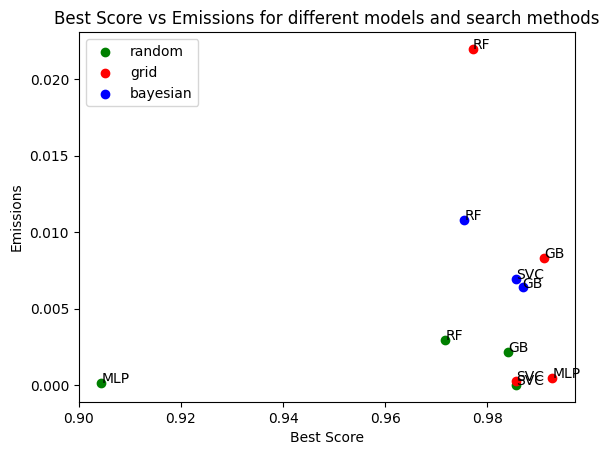

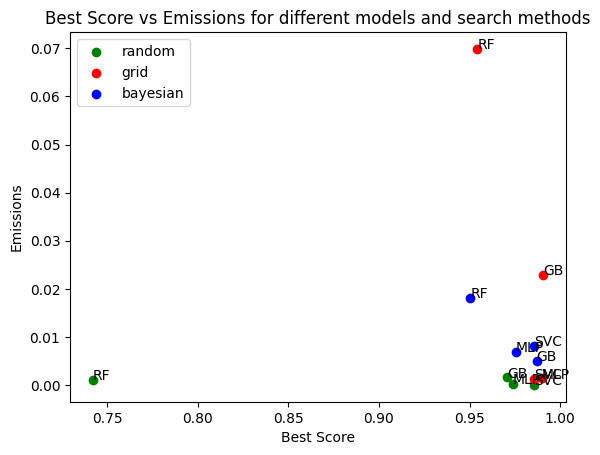

In [23]:
model_names = ["SVC", "RF", "MLP", "GB"]

results_list_little = [
    svc_dict_little,
    rf_dict_little,
    mlp_dict_little,
    gbr_dict_little,
]
results_list_medium = [
    svc_dict_medium,
    rf_dict_medium,
    mlp_dict_medium,
    gbr_dict_medium,
]
results_list_big = [svc_dict_big, rf_dict_big, mlp_dict_big, gbr_dict_big]

plot_all_results(results_list_little, model_names)
plot_all_results(results_list_medium, model_names)
plot_all_results(results_list_big, model_names)

In [24]:
# print time and emissions for each model in a dataframe
def results_to_df(results_list, model_names):
    results_df = pd.DataFrame(columns=["Model", "Search Method", "Time", "Emissions"])

    for i, result_dict in enumerate(results_list):
        for search_method in result_dict.keys():
            results_df = pd.concat(
                [
                    results_df,
                    pd.DataFrame(
                        {
                            "Model": model_names[i],
                            "Search Method": search_method,
                            "Time": result_dict[search_method]["time"],
                            "Emissions": result_dict[search_method]["emissions"],
                        },
                        index=[0],
                    ),
                ]
            )
    return results_df

In [25]:
results_df_little = results_to_df(results_list_little, model_names)

print(results_df_little)

  Model Search Method       Time  Emissions
0   SVC        random   4.838316   0.001438
0   SVC          grid   0.114032   0.000038
0   SVC      bayesian  17.005823   0.011845
0    RF        random   1.642340   0.000569
0    RF          grid   2.912666   0.000908
0    RF      bayesian  27.138805   0.008780
0   MLP        random   0.501048   0.000180
0   MLP          grid   0.439163   0.000162
0   MLP      bayesian  24.773460   0.008133
0    GB        random   0.850531   0.000398
0    GB          grid   1.085352   0.000379
0    GB      bayesian  34.404012   0.010844


/var/folders/1q/12kg_kfs23s79nvvww18_nvc0000gn/T/ipykernel_11197/3941389364.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Model': model_names[i], 'Search Method': search_method, 'Time': result_dict[search_method]['time'], 'Emissions': result_dict[search_method]['emissions']}, index=[0])])


In [26]:
results_df_medium = results_to_df(results_list_medium, model_names)

print(results_df_medium)

  Model Search Method       Time  Emissions
0   SVC        random   0.072350   0.000027
0   SVC          grid   0.845201   0.000291
0   SVC      bayesian  19.453180   0.006971
0    RF        random   8.403278   0.002956
0    RF          grid  64.004942   0.021966
0    RF      bayesian  30.127980   0.010814
0   MLP        random   0.482213   0.000178
0   MLP          grid   1.578676   0.000496
0   MLP      bayesian  16.759634        NaN
0    GB        random   5.494839   0.002189
0    GB          grid  24.668513   0.008301
0    GB      bayesian  22.972718   0.006401


/var/folders/1q/12kg_kfs23s79nvvww18_nvc0000gn/T/ipykernel_11197/3941389364.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Model': model_names[i], 'Search Method': search_method, 'Time': result_dict[search_method]['time'], 'Emissions': result_dict[search_method]['emissions']}, index=[0])])


In [27]:
results_df_big = results_to_df(results_list_big, model_names)

print(results_df_big)

  Model Search Method        Time  Emissions
0   SVC        random    0.074626   0.000029
0   SVC          grid    3.450638   0.001201
0   SVC      bayesian   22.587261   0.008154
0    RF        random    6.515771   0.001104
0    RF          grid  198.064680   0.069874
0    RF      bayesian   52.701759   0.018199
0   MLP        random    0.742903   0.000252
0   MLP          grid    4.047343   0.001367
0   MLP      bayesian   21.615530   0.006881
0    GB        random    4.741863   0.001611
0    GB          grid   69.854502   0.022983
0    GB      bayesian   19.904336   0.004996


/var/folders/1q/12kg_kfs23s79nvvww18_nvc0000gn/T/ipykernel_11197/3941389364.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Model': model_names[i], 'Search Method': search_method, 'Time': result_dict[search_method]['time'], 'Emissions': result_dict[search_method]['emissions']}, index=[0])])
